### Imports and Setup

Imports necessary libraries: 
- `numpy` for numerical operations
- `tensorflow` for dataset loading 
- `sklearn.metrics` for evaluation
- `matplotlib.pyplot` for plotting.

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math 

### Data Loading and Preprocessing

The `load_and_preprocess_data_multiclass` function handles:
- Loading the **CIFAR-10 dataset**.
- Normalizing image pixel values to the [0, 1] range.
- Flattening images into vectors.
- **One-hot encoding** the labels for multiclass classification.
- Splitting the training data into training and validation sets.
It returns processed training, validation, and test sets, along with original integer labels for the test set for evaluation.

In [10]:
def load_and_preprocess_data_multiclass(validation_split_ratio=0.1):
    (x_train_full, y_train_full), (x_test_full, y_test_full) = \
        tf.keras.datasets.cifar10.load_data()

    print(f"Original training data size: {x_train_full.shape[0]}")
    print(f"Original test data size: {x_test_full.shape[0]}")

    # Normalize
    x_train_normalized = x_train_full.astype('float32') / 255.0
    x_test_normalized = x_test_full.astype('float32') / 255.0

    # Flatten
    x_train_flattened = x_train_normalized.reshape(x_train_normalized.shape[0], -1)
    x_test_flattened = x_test_normalized.reshape(x_test_normalized.shape[0], -1)

    # One-hot encode labels
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_full, num_classes=10)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test_full, num_classes=10)
    y_test_int_labels = y_test_full.copy() # Keep original integer labels for evaluation

    # Shuffle and split training data
    num_train_samples = x_train_flattened.shape[0]
    permutation = np.random.permutation(num_train_samples)
    shuffled_X = x_train_flattened[permutation]
    shuffled_Y_one_hot = y_train_one_hot[permutation]

    split_idx = int(num_train_samples * (1 - validation_split_ratio))

    x_train_final = shuffled_X[:split_idx]
    y_train_final_one_hot = shuffled_Y_one_hot[:split_idx]
    x_val_final = shuffled_X[split_idx:]
    y_val_final_one_hot = shuffled_Y_one_hot[split_idx:]

    print("--- Processed Data Shapes ---")
    print(f"x_train_final: {x_train_final.shape}, y_train_final_one_hot: {y_train_final_one_hot.shape}")
    print(f"x_val_final: {x_val_final.shape}, y_val_final_one_hot: {y_val_final_one_hot.shape}")
    print(f"x_test_flattened: {x_test_flattened.shape}, y_test_one_hot: {y_test_one_hot.shape}")
    print(f"y_test_int_labels: {y_test_int_labels.shape}") # For final evaluation
    print("-----------------------------")

    return (x_train_final, y_train_final_one_hot,
            x_val_final, y_val_final_one_hot,
            x_test_flattened, y_test_one_hot,
            y_test_int_labels)

### Activation and Loss Functions

This section defines essential functions for the neural network:
- `sigmoid`: The sigmoid activation function, $ \sigma(z) = \frac{1}{1 + e^{-z}} $, typically used in hidden layers.
- `softmax`: The softmax activation function, often used in the output layer for multiclass classification to convert logits to probabilities. It's stabilized by subtracting the max value of $z$.
- `multiclass_cross_entropy_loss`: Calculates the cross-entropy loss for multiclass problems. Predictions are clipped to avoid `log(0)`.

In [11]:
def sigmoid(z):
    z_clipped = np.clip(z, -500, 500)
    s = 1 / (1 + np.exp(-z_clipped))
    return s

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def multiclass_cross_entropy_loss(Y_true_one_hot, Y_pred_softmax):
    m = Y_true_one_hot.shape[1]
    epsilon = 1e-12 # Small value to prevent log(0)
    Y_pred_softmax_clipped = np.clip(Y_pred_softmax, epsilon, 1. - epsilon)
    cost = - (1 / m) * np.sum(Y_true_one_hot * np.log(Y_pred_softmax_clipped))
    return np.squeeze(cost)

### Neural Network Implementation

These functions build a one-hidden-layer neural network:
- `define_layer_sizes_multiclass`: Specifies the number of neurons in the input, hidden, and output layers.
- `initialize_parameters_multiclass`: Initializes weights using **He initialization** and biases to zero.
- `forward_propagation_multiclass`: Performs the forward pass, calculating $Z^{[1]}, A^{[1]}$ (sigmoid activation) and $Z^{[2]}, A^{[2]}$ (softmax activation).
- `backward_propagation_multiclass`: Computes the gradients ($dW^{[1]}, db^{[1]}, dW^{[2]}, db^{[2]}$) required for learning.
- `update_parameters`: Updates model parameters using gradient descent.

In [12]:
def define_layer_sizes_multiclass(X_input_cols, n_h, n_y_multiclass=10):
    n_x = X_input_cols # Number of features from input data shape
    return n_x, n_h, n_y_multiclass

def initialize_parameters_multiclass(n_x, n_h, n_y):
    np.random.seed(42) # For reproducibility
    # He initialization for weights
    W1 = np.random.randn(n_h, n_x) * np.sqrt(2. / n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * np.sqrt(2. / n_h)
    b2 = np.zeros((n_y, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

def forward_propagation_multiclass(X_input, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]

    Z1 = np.dot(W1, X_input) + b1
    A1 = sigmoid(Z1) # Hidden layer activation
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2) # Output layer activation (probabilities)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def backward_propagation_multiclass(parameters, cache, X_input, Y_one_hot_true):
    m = X_input.shape[1]
    W2 = parameters["W2"] 
    A1, A2 = cache["A1"], cache["A2"] # Activations from forward pass

    # Gradient for Layer 2 (Output layer: Softmax with Cross-Entropy)
    dZ2 = A2 - Y_one_hot_true
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Gradient for Layer 1 (Hidden layer: Sigmoid)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (A1 * (1 - A1)) # Derivative of sigmoid: A1 * (1 - A1)
    dW1 = (1 / m) * np.dot(dZ1, X_input.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

def update_parameters(parameters, grads, learning_rate):
    updated_params = {}
    # Standard gradient descent update rule
    for key in parameters.keys(): # W1, b1, W2, b2
        updated_params[key] = parameters[key] - learning_rate * grads['d' + key]
    return updated_params

### Model Training and Evaluation

- `create_minibatches`: A utility function to divide the dataset into smaller batches for **mini-batch gradient descent**. This helps in faster training and can lead to better generalization.
- `nn_model_multiclass_advanced`: This is the main training loop. It initializes parameters, iterates through epochs, processes data in mini-batches, performs forward and backward propagation, updates parameters, and calculates training/validation loss. It incorporates **early stopping** to prevent overfitting by monitoring validation loss. Finally, it evaluates the best model on the test set using a classification report and overall accuracy.

In [13]:
def create_minibatches(X_input, Y_labels, minibatch_size=128, seed=0):
    np.random.seed(seed)
    m = X_input.shape[1] # Number of training examples
    minibatches = []

    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X_input[:, permutation]
    shuffled_Y = Y_labels[:, permutation]

    # Partition into minibatches
    num_complete_minibatches = math.floor(m / minibatch_size)
    for k in range(num_complete_minibatches):
        minibatch_X = shuffled_X[:, k * minibatch_size : (k + 1) * minibatch_size]
        minibatch_Y = shuffled_Y[:, k * minibatch_size : (k + 1) * minibatch_size]
        minibatches.append((minibatch_X, minibatch_Y))

    # Handle the last, possibly smaller, minibatch
    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[:, num_complete_minibatches * minibatch_size :]
        minibatch_Y = shuffled_Y[:, num_complete_minibatches * minibatch_size :]
        minibatches.append((minibatch_X, minibatch_Y))
    return minibatches

In [14]:

def nn_model_multiclass_advanced(
        X_train_data, Y_train_one_hot_data, X_val_data, Y_val_one_hot_data,
        X_test_data, Y_test_int_labels_data, # Y_test_one_hot is not directly used here
        n_h, num_epochs=100, minibatch_size=128, learning_rate=0.01,
        patience_early_stopping=10, print_cost_every_n_epochs=1):

    # Transpose data for internal calculations: (features/classes, samples)
    X_train_t = X_train_data.T
    Y_train_one_hot_t = Y_train_one_hot_data.T
    X_val_t = X_val_data.T
    Y_val_one_hot_t = Y_val_one_hot_data.T
    X_test_t = X_test_data.T

    n_x, _, n_y = define_layer_sizes_multiclass(X_train_data.shape[1], n_h, Y_train_one_hot_data.shape[1])
    parameters = initialize_parameters_multiclass(n_x, n_h, n_y)

    train_costs, val_costs = [], []
    best_val_cost = float('inf')
    epochs_no_improve = 0
    best_parameters = {k: v.copy() for k, v in parameters.items()} # Deep copy
    current_seed = 0
    actual_epochs_run = 0

    print(f"\n--- Training Multiclass Neural Network ---")
    print(f"Architecture: Input={n_x}, Hidden={n_h}, Output={n_y}")
    print(f"Epochs={num_epochs}, LR={learning_rate}, BatchSize={minibatch_size}, Patience={patience_early_stopping}\n")

    for epoch in range(num_epochs):
        actual_epochs_run = epoch + 1
        current_seed += 1 # Ensure different shuffling for minibatches each epoch
        epoch_cost_sum = 0.0
        minibatches = create_minibatches(X_train_t, Y_train_one_hot_t, minibatch_size, current_seed)

        for minibatch_X, minibatch_Y in minibatches:
            A2_mini, cache_mini = forward_propagation_multiclass(minibatch_X, parameters)
            cost_mini = multiclass_cross_entropy_loss(minibatch_Y, A2_mini)
            epoch_cost_sum += cost_mini
            grads = backward_propagation_multiclass(parameters, cache_mini, minibatch_X, minibatch_Y)
            parameters = update_parameters(parameters, grads, learning_rate)

        avg_train_cost = epoch_cost_sum / len(minibatches)
        train_costs.append(avg_train_cost)

        A2_val, _ = forward_propagation_multiclass(X_val_t, parameters)
        current_val_cost = multiclass_cross_entropy_loss(Y_val_one_hot_t, A2_val)
        val_costs.append(current_val_cost)

        if (epoch + 1) % print_cost_every_n_epochs == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Cost: {avg_train_cost:.6f} - Val Cost: {current_val_cost:.6f}")

        if current_val_cost < best_val_cost:
            best_val_cost = current_val_cost
            best_parameters = {k: v.copy() for k, v in parameters.items()} # Deep copy best parameters
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience_early_stopping:
                print(f"Early stopping: Epoch {epoch+1}. Best val cost: {best_val_cost:.6f}")
                parameters = best_parameters # Restore best parameters before stopping
                break
    parameters = best_parameters # Ensure the best parameters are used for evaluation

    A2_test, _ = forward_propagation_multiclass(X_test_t, parameters)
    Y_pred_test_indices = np.argmax(A2_test, axis=0) # Get predicted class indices

    print(f"\n--- Model Evaluation on Test Set ---")
    # Ensure Y_test_int_labels_data is 1D array for classification_report
    Y_test_int_flat = Y_test_int_labels_data.flatten()
    print("Classification Report:\n", classification_report(Y_test_int_flat, Y_pred_test_indices, zero_division=0))

    accuracy = np.mean(Y_pred_test_indices == Y_test_int_flat) * 100
    print(f"Overall Test Accuracy: {accuracy:.2f}%")

    history = {"train_costs": train_costs, "val_costs": val_costs, "epochs_run": actual_epochs_run}
    results = {"parameters": parameters, "history": history, "learning_rate": learning_rate,
               "num_epochs_conf": num_epochs, "n_h": n_h, "accuracy": accuracy,
               "minibatch_size": minibatch_size}
    return results

### Plotting Function

The `plot_train_val_costs` function visualizes the training and validation loss over epochs. This plot is crucial for understanding the model's learning behavior, such as identifying overfitting or determining if more training is needed.

In [15]:
def plot_train_val_costs(history_data, lr, n_h_nodes, batch_s):
    train_c = history_data["train_costs"]
    val_c = history_data["val_costs"]
    epochs_r = range(1, history_data["epochs_run"] + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_r, train_c, label='Training Cost', marker='.')
    plt.plot(epochs_r, val_c, label='Validation Cost', marker='.')
    plt.ylabel('Cost (Multiclass Cross-Entropy)')
    plt.xlabel('Epochs')
    plt.title(f'Training & Validation Cost (Hidden: {n_h_nodes}, LR: {lr}, Batch: {batch_s})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Main Execution Block

This is the main script execution block. It:
1. Sets **hyperparameters** for the neural network (hidden layer size, epochs, learning rate, etc.).
2. Calls `load_and_preprocess_data_multiclass` to get the data.
3. Trains the model using `nn_model_multiclass_advanced`.
4. Calls `plot_train_val_costs` to visualize the learning curves.
5. Prints a summary of the final results, including the test accuracy.

Original training data size: 50000
Original test data size: 10000
--- Processed Data Shapes ---
x_train_final: (42500, 3072), y_train_final_one_hot: (42500, 10)
x_val_final: (7500, 3072), y_val_final_one_hot: (7500, 10)
x_test_flattened: (10000, 3072), y_test_one_hot: (10000, 10)
y_test_int_labels: (10000, 1)
-----------------------------

--- Training Multiclass Neural Network ---
Architecture: Input=3072, Hidden=128, Output=10
Epochs=1000, LR=0.01, BatchSize=128, Patience=20

Epoch 10/1000 - Train Cost: 1.833751 - Val Cost: 1.859154
Epoch 20/1000 - Train Cost: 1.764750 - Val Cost: 1.804860
Epoch 30/1000 - Train Cost: 1.724792 - Val Cost: 1.757054
Epoch 40/1000 - Train Cost: 1.689272 - Val Cost: 1.750987
Epoch 50/1000 - Train Cost: 1.660043 - Val Cost: 1.705251
Epoch 60/1000 - Train Cost: 1.626696 - Val Cost: 1.673380
Epoch 70/1000 - Train Cost: 1.600198 - Val Cost: 1.653081
Epoch 80/1000 - Train Cost: 1.579137 - Val Cost: 1.657891
Epoch 90/1000 - Train Cost: 1.553163 - Val Cost: 1.66

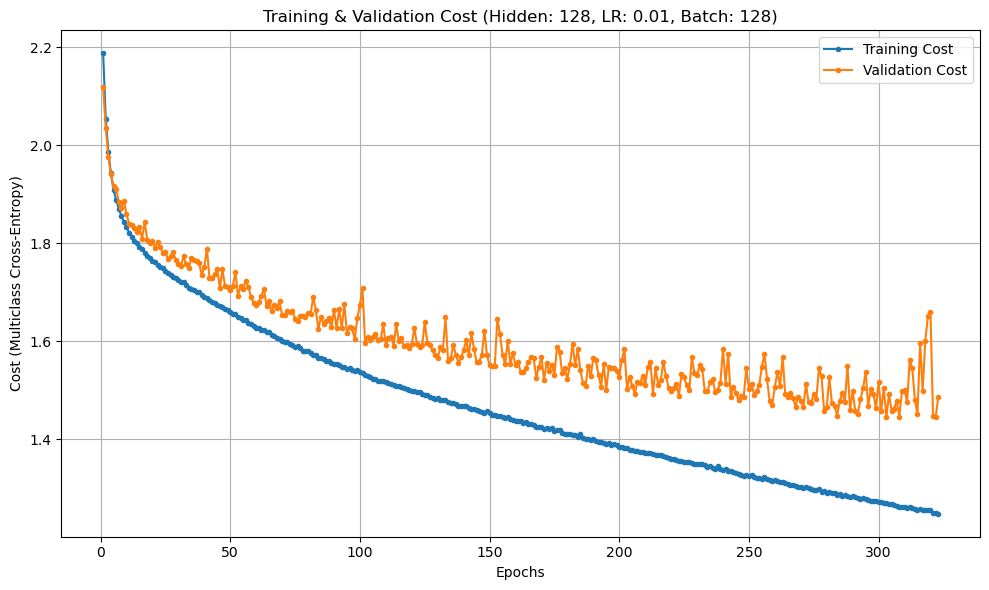


--- Final Summary (Multiclass NN) ---
Hidden Layer Neurons: 128
Learning Rate: 0.01, Configured Epochs: 1000
Actual Epochs Run: 323
Mini-batch Size: 128
Overall Test Accuracy: 49.77%


In [16]:
if __name__ == "__main__":
    # Load and preprocess data
    (x_train, y_train_oh,
     x_val, y_val_oh,
     x_test, _,
     y_test_int) = load_and_preprocess_data_multiclass(validation_split_ratio=0.15)

    # Hyperparameters
    HIDDEN_LAYER_NODES = 128  # Increased hidden layer size
    NUM_EPOCHS = 1000        # Max number of training iterations
    LEARNING_RATE = 0.01  # Adjusted learning rate
    MINIBATCH_SIZE = 128     # Mini-batch size
    PATIENCE = 20           # Patience for early stopping
    PRINT_EVERY = 10        # Frequency of printing training progress

    # Train the model
    model_results = nn_model_multiclass_advanced(
        x_train, y_train_oh, x_val, y_val_oh, x_test, y_test_int,
        n_h=HIDDEN_LAYER_NODES,
        num_epochs=NUM_EPOCHS,
        minibatch_size=MINIBATCH_SIZE,
        learning_rate=LEARNING_RATE,
        patience_early_stopping=PATIENCE,
        print_cost_every_n_epochs=PRINT_EVERY
    )

    # Plot results if training completed
    if model_results and "history" in model_results:
        plot_train_val_costs(
            model_results["history"],
            model_results["learning_rate"],
            model_results["n_h"],
            model_results["minibatch_size"]
        )

    # Print final summary
    print(f"\n--- Final Summary (Multiclass NN) ---")
    if model_results:
        print(f"Hidden Layer Neurons: {model_results['n_h']}")
        print(f"Learning Rate: {model_results['learning_rate']}, Configured Epochs: {model_results['num_epochs_conf']}")
        print(f"Actual Epochs Run: {model_results['history']['epochs_run']}")
        print(f"Mini-batch Size: {model_results['minibatch_size']}")
        print(f"Overall Test Accuracy: {model_results['accuracy']:.2f}%")
    else:
        print("Model training did not produce results.")